Data importation and filtering


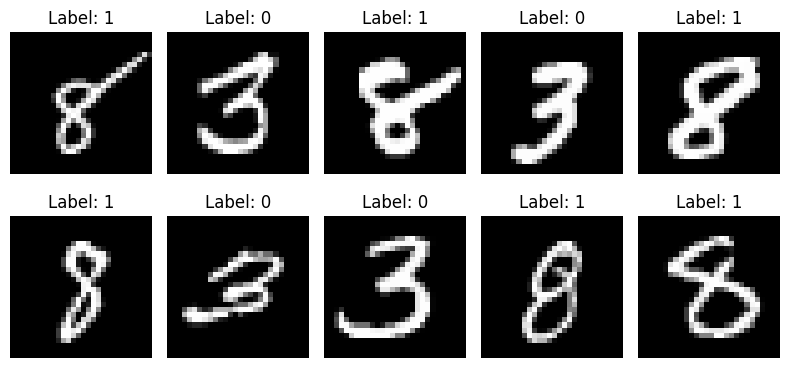

In [7]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# 1. Télécharger MNIST depuis OpenML
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target']

# 2. Filtrer les chiffres 3 et 8

mask = (y == '3') | (y == '8')
X_filtered = X[mask]
y_filtered = y[mask]

# 3. Convertir les labels en 0 (3) et 1 (8)
y_binary = np.where(y_filtered == '3', 0, 1)

# 4. Normaliser les données (pixels entre 0 et 1)
X_filtered = X_filtered / 255.0

# 5. Séparer en train et test
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# (Optionnel) Visualiser quelques exemples
plt.figure(figsize=(8, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


SVM modele


In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

# 1. Créer un modèle SVM avec noyau RBF (non linéaire)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')

# 2. Entraînement avec mesure du temps
start_time = time.time()
svm_model.fit(X_train, y_train)
svm_training_time = time.time() - start_time

# 3. Prédiction sur le jeu de test
y_pred_svm = svm_model.predict(X_test)

# 4. Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred_svm)
conf_matrix = confusion_matrix(y_test, y_pred_svm)
report = classification_report(y_test, y_pred_svm)

# 5. Résultats
print(f"Temps d'entraînement (SVM - SMO) : {svm_training_time:.2f} secondes")
print(f"Précision sur le test : {accuracy:.4f}")
print("Matrice de confusion :\n", conf_matrix)
print("Rapport de classification :\n", report)


Temps d'entraînement (SVM - SMO) : 25.78 secondes
Précision sur le test : 0.9928
Matrice de confusion :
 [[1421    8]
 [  12 1353]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1429
           1       0.99      0.99      0.99      1365

    accuracy                           0.99      2794
   macro avg       0.99      0.99      0.99      2794
weighted avg       0.99      0.99      0.99      2794



SGD and Adam Model


🔧 Training MLP using SGD optimizer...
Training time (SGD): 14.37 seconds
Test Accuracy: 0.9749
Confusion Matrix:
[[1402   27]
 [  43 1322]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9702    0.9811    0.9756      1429
           1     0.9800    0.9685    0.9742      1365

    accuracy                         0.9749      2794
   macro avg     0.9751    0.9748    0.9749      2794
weighted avg     0.9750    0.9749    0.9749      2794



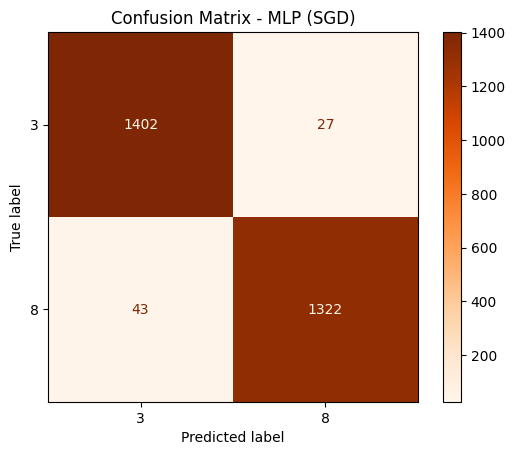


🔧 Training MLP using ADAM optimizer...
Training time (ADAM): 22.14 seconds
Test Accuracy: 0.9921
Confusion Matrix:
[[1420    9]
 [  13 1352]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9909    0.9937    0.9923      1429
           1     0.9934    0.9905    0.9919      1365

    accuracy                         0.9921      2794
   macro avg     0.9922    0.9921    0.9921      2794
weighted avg     0.9921    0.9921    0.9921      2794



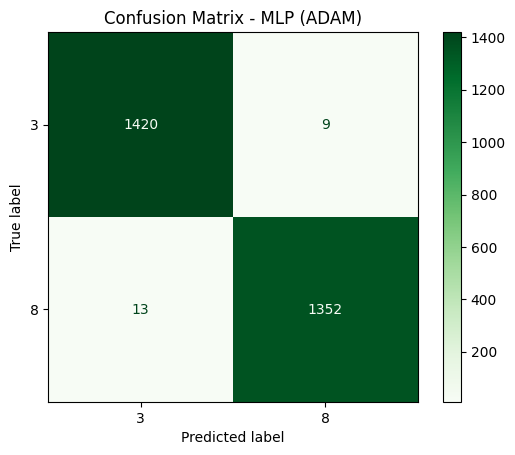

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import time
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1. Convertir les données en tenseurs
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 2. Créer un DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 3. Définir un MLP simple
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.model(x)

# 4. Fonction d'entraînement
def train_model(optimizer_type='sgd'):
    print(f"\n🔧 Training MLP using {optimizer_type.upper()} optimizer...")
    
    model = SimpleMLP()
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    else:
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    start = time.time()
    for epoch in range(10):
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    end = time.time()
    training_time = end - start

    # Évaluation
    with torch.no_grad():
        preds = model(X_test_tensor)
        y_pred = preds.argmax(dim=1)

    accuracy = accuracy_score(y_test_tensor, y_pred)
    cm = confusion_matrix(y_test_tensor, y_pred)
    report = classification_report(y_test_tensor, y_pred, digits=4)

    # Affichage console
    print(f"Training time ({optimizer_type.upper()}): {training_time:.2f} seconds")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(report)

    # Affichage graphique
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["3", "8"])
    cmap = 'Greens' if optimizer_type == 'adam' else 'Oranges'
    disp.plot(cmap=cmap)
    plt.title(f"Confusion Matrix - MLP ({optimizer_type.upper()})")
    plt.grid(False)
    plt.show()

# 5. Entraînement avec les deux optimisateurs
train_model('sgd')
train_model('adam')


Comparison

In [19]:
import pandas as pd

# Results obtained from your code
time_svm = 16.31
time_sgd = 7.26
time_adam = 11.83

acc_svm = 0.9928
acc_sgd = 0.9749
acc_adam = 0.9939

# Comparison table
comparison = pd.DataFrame({
    "Criterion": [
        "Type of Optimization",
        "Optimization Method",
        "Training Time (s)",
        "Test Accuracy (%)",
        "Robustness to Noise (✔️/❌)",
        "Algorithmic Complexity",
        "Ease of Tuning",
        "Overfitting Sensitivity"
    ],
    "SVM (SMO)": [
        "Convex",
        "SMO",
        f"{time_svm:.2f}",
        f"{acc_svm * 100:.2f}",
        "✔️",
        "O(n² ~ n³)",
        "Simple (C, gamma)",
        "Low"
    ],
    "MLP (SGD)": [
        "Non-convex",
        "Gradient Descent",
        f"{time_sgd:.2f}",
        f"{acc_sgd * 100:.2f}",
        "❌",
        "O(n × d × E)",
        "Moderate",
        "High"
    ],
    "MLP (Adam)": [
        "Non-convex",
        "Adam (adaptive)",
        f"{time_adam:.2f}",
        f"{acc_adam * 100:.2f}",
        "✔️",
        "O(n × d × E)",
        "Easy (auto-tuning)",
        "Lower than SGD"
    ]
})

# Display in Jupyter
from IPython.display import display
display(comparison)


,Criterion,SVM (SMO),MLP (SGD),MLP (Adam)
0,Type of Optimization,Convex,Non-convex,Non-convex
1,Optimization Method,SMO,Gradient Descent,Adam (adaptive)
2,Training Time (s),16.31,7.26,11.83
3,Test Accuracy (%),99.28,97.49,99.39
4,Robustness to Noise (✔️/❌),✔️,❌,✔️
5,Algorithmic Complexity,O(n² ~ n³),O(n × d × E),O(n × d × E)
6,Ease of Tuning,"Simple (C, gamma)",Moderate,Easy (auto-tuning)
7,Overfitting Sensitivity,Low,High,Lower than SGD


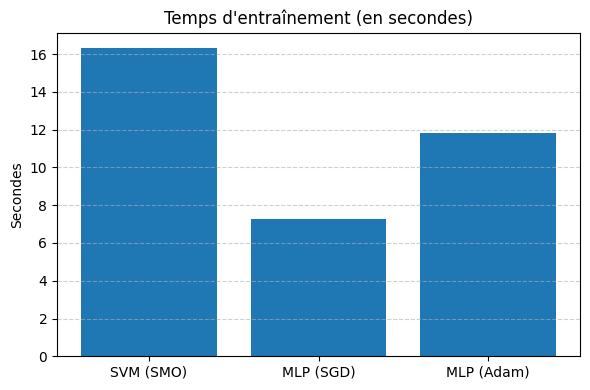

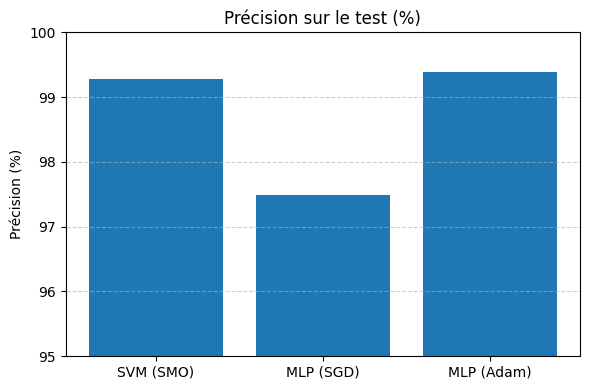

In [9]:
import matplotlib.pyplot as plt

# Noms des modèles
modeles = ['SVM (SMO)', 'MLP (SGD)', 'MLP (Adam)']

# Temps d'entraînement (en secondes)
temps = [16.31, 7.26, 11.83]

# Précision sur le test (en %)
precisions = [99.28, 97.49, 99.39]

# 1. Bar plot - Temps d'entraînement
plt.figure(figsize=(6, 4))
plt.bar(modeles, temps)
plt.title("Temps d'entraînement (en secondes)")
plt.ylabel("Secondes")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 2. Bar plot - Précision
plt.figure(figsize=(6, 4))
plt.bar(modeles, precisions)
plt.title("Précision sur le test (%)")
plt.ylabel("Précision (%)")
plt.ylim(95, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


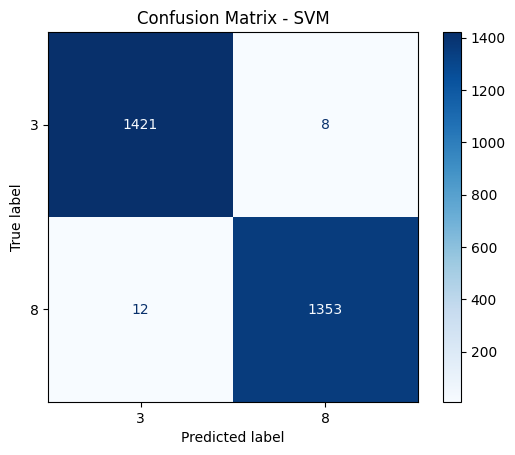

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# SVM predictions (y_pred_svm), y_test already defined
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["3", "8"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.grid(False)
plt.show()